# Pneumonia Detection - Model Prediction Testing

This notebook demonstrates how to test your trained model on new chest X-ray images to verify its predictions.

## Import Required Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## Load Your Trained Model

Make sure you have your best trained model file (.h5) in the current directory.

In [3]:
# List available model files
model_files = [f for f in os.listdir('.') if f.endswith('.h5')]
print("Available model files:")
for i, file in enumerate(model_files):
    print(f"{i+1}. {file}")

# Load the best model (change filename if needed)
if model_files:
    model_path = model_files[0]  # Use first available model
    print(f"\n🔄 Loading model: {model_path}")
    
    try:
        model = load_model(model_path)
        print(f"✅ Model loaded successfully!")
        print(f"📊 Model architecture: {model.name}")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
else:
    print("❌ No model files found! Please train a model first using pneumonia.ipynb")

Available model files:
1. chexnet_best.h5

🔄 Loading model: chexnet_best.h5


✅ Model loaded successfully!
📊 Model architecture: functional_2


## Setup Test Data Generator

Let's create a data generator to load test images systematically.

In [4]:
# Setup test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Try to find test directory
test_dirs = ['./DATASET/chest_xray_balanced/test', './DATASET/chest_xray/test']
test_dir = None

for dir_path in test_dirs:
    if os.path.exists(dir_path):
        test_dir = dir_path
        print(f"✅ Found test directory: {test_dir}")
        break

if test_dir:
    # Create test generator
    test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=1,
        class_mode='binary',
        shuffle=False  # Keep order for proper comparison
    )
    
    print(f"📊 Test generator created with {test_gen.samples} samples")
    print(f"🏷️ Class indices: {test_gen.class_indices}")
else:
    print("❌ Test directory not found! Please extract DATASET.zip first.")

✅ Found test directory: ./DATASET/chest_xray_balanced/test
Found 468 images belonging to 2 classes.
📊 Test generator created with 468 samples
🏷️ Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


## Test Single Image Prediction

Let's test the model on individual images to see how it performs.

In [5]:
def predict_single_image(model, image_path, show_image=True):
    """
    Predict pneumonia for a single image and display results
    """
    # Load and preprocess image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction_prob = model.predict(img_array, verbose=0)[0][0]
    
    # Determine class and confidence
    if prediction_prob > 0.5:
        predicted_class = 'PNEUMONIA'
        confidence = prediction_prob
    else:
        predicted_class = 'NORMAL'
        confidence = 1 - prediction_prob
    
    # Get actual class from path
    actual_class = 'PNEUMONIA' if 'PNEUMONIA' in image_path.upper() else 'NORMAL'
    is_correct = predicted_class == actual_class
    
    # Display results
    if show_image:
        plt.figure(figsize=(12, 5))
        
        # Show image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Chest X-ray\n{os.path.basename(image_path)}')
        
        # Show prediction results
        plt.subplot(1, 2, 2)
        plt.axis('off')
        
        # Create text summary
        result_text = f"""
PREDICTION RESULTS

🔮 Predicted: {predicted_class}
✅ Actual: {actual_class}
📊 Confidence: {confidence:.1%}
📈 Raw Score: {prediction_prob:.4f}

{'✅ CORRECT' if is_correct else '❌ INCORRECT'}

Model Logic:
• Score > 0.5 = PNEUMONIA
• Score ≤ 0.5 = NORMAL
"""
        
        plt.text(0.1, 0.5, result_text, fontsize=11, 
                verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.5", 
                         facecolor='lightgreen' if is_correct else 'lightcoral',
                         alpha=0.8))
        
        plt.tight_layout()
        plt.show()
    
    # Print summary
    print(f"\n📋 {os.path.basename(image_path)}")
    print(f"🔮 Predicted: {predicted_class} ({confidence:.1%})")
    print(f"✅ Actual: {actual_class}")
    print(f"{'✅ CORRECT' if is_correct else '❌ INCORRECT'} - Raw score: {prediction_prob:.4f}")
    
    return {
        'image_path': image_path,
        'predicted_class': predicted_class,
        'actual_class': actual_class,
        'confidence': confidence,
        'raw_probability': prediction_prob,
        'is_correct': is_correct
    }

print("✅ Single image prediction function ready!")

✅ Single image prediction function ready!


## Test Random Sample Images

Let's test the model on random images from the test set to see how well it performs.

📊 Found 468 test images

🔍 Testing on 5 random images...

[1/5] Testing: IM-0103-0001.jpeg


C:\Users\LOQ\AppData\Local\Temp\ipykernel_34704\1255307070.py:62: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LOQ\AppData\Local\Temp\ipykernel_34704\1255307070.py:62: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LOQ\AppData\Local\Temp\ipykernel_34704\1255307070.py:62: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LOQ\AppData\Local\Temp\ipykernel_34704\1255307070.py:62: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\LOQ\Downloads\PNEUMONIA DETECTION\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\LOQ\Downloads\PNEUMONIA DETECTION\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: 

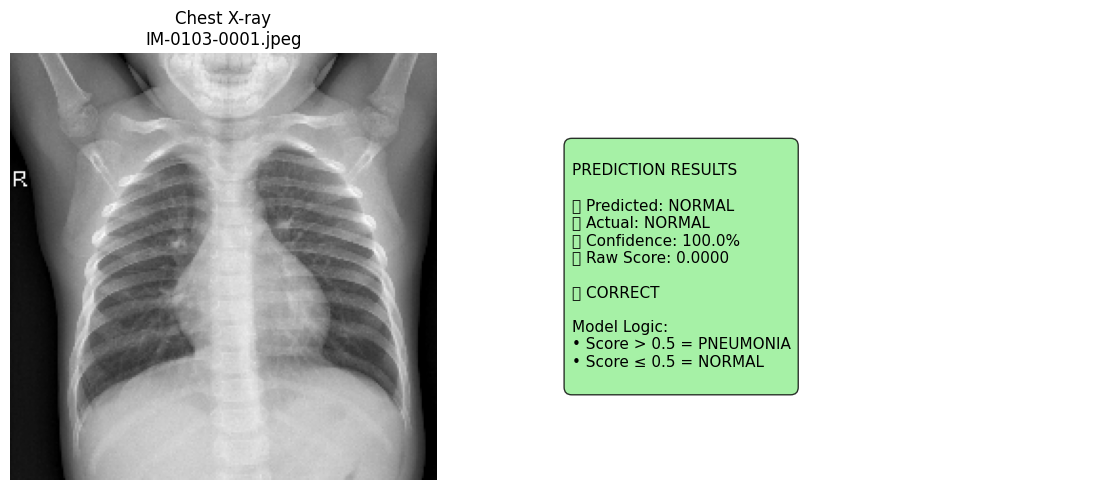


📋 IM-0103-0001.jpeg
🔮 Predicted: NORMAL (100.0%)
✅ Actual: NORMAL
✅ CORRECT - Raw score: 0.0000

[2/5] Testing: person25_virus_59.jpeg


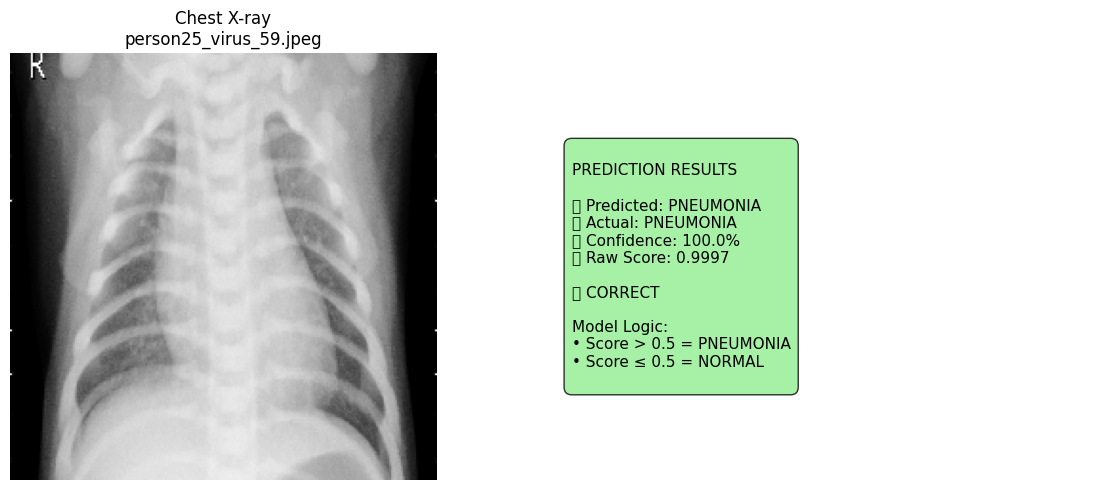


📋 person25_virus_59.jpeg
🔮 Predicted: PNEUMONIA (100.0%)
✅ Actual: PNEUMONIA
✅ CORRECT - Raw score: 0.9997

[3/5] Testing: person133_bacteria_638.jpeg


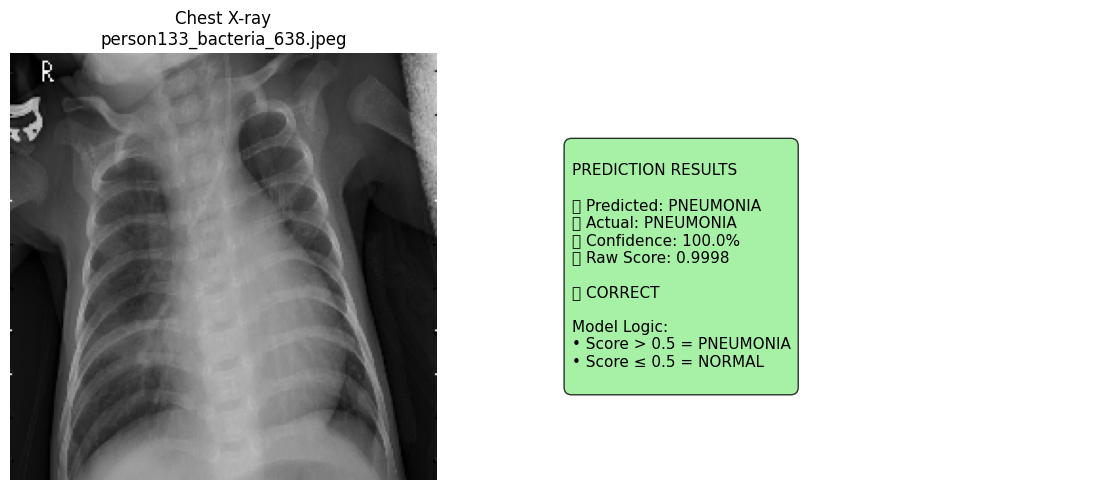


📋 person133_bacteria_638.jpeg
🔮 Predicted: PNEUMONIA (100.0%)
✅ Actual: PNEUMONIA
✅ CORRECT - Raw score: 0.9998

[4/5] Testing: IM-0101-0001.jpeg


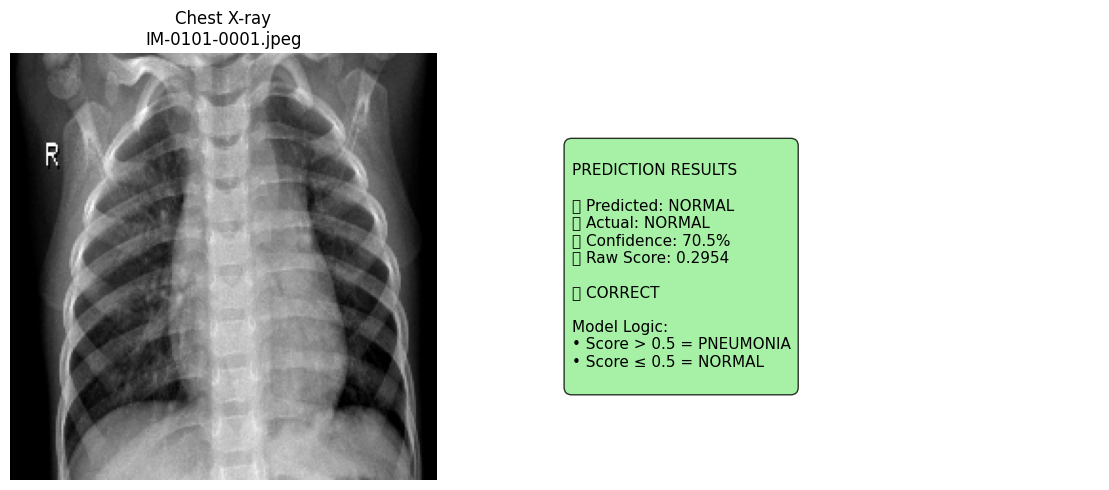


📋 IM-0101-0001.jpeg
🔮 Predicted: NORMAL (70.5%)
✅ Actual: NORMAL
✅ CORRECT - Raw score: 0.2954

[5/5] Testing: person30_virus_69.jpeg


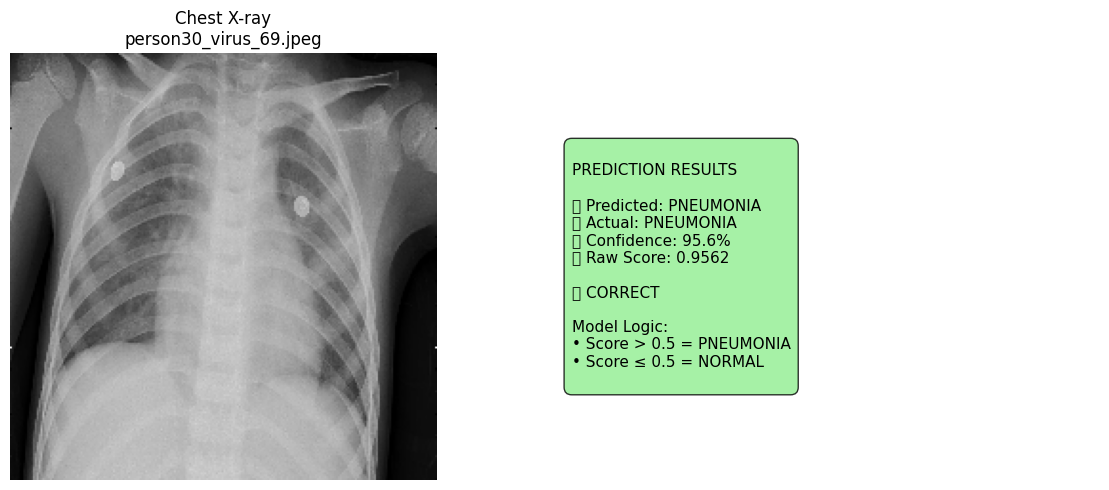


📋 person30_virus_69.jpeg
🔮 Predicted: PNEUMONIA (95.6%)
✅ Actual: PNEUMONIA
✅ CORRECT - Raw score: 0.9562

📊 SAMPLE TEST RESULTS:
Total tested: 5
Correct: 5
Incorrect: 0
Sample Accuracy: 100.0%


In [6]:
if test_dir and os.path.exists(test_dir):
    # Get all test image paths
    all_test_images = []
    for root, dirs, files in os.walk(test_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_test_images.append(os.path.join(root, file))
    
    print(f"📊 Found {len(all_test_images)} test images")
    
    # Test on random sample
    num_samples = 5  # Change this number to test more/fewer images
    sample_images = random.sample(all_test_images, min(num_samples, len(all_test_images)))
    
    print(f"\n🔍 Testing on {len(sample_images)} random images...")
    print("=" * 60)
    
    results = []
    for i, img_path in enumerate(sample_images, 1):
        print(f"\n[{i}/{len(sample_images)}] Testing: {os.path.basename(img_path)}")
        result = predict_single_image(model, img_path, show_image=True)
        results.append(result)
    
    # Summary
    correct_count = sum(1 for r in results if r['is_correct'])
    accuracy = correct_count / len(results)
    
    print(f"\n📊 SAMPLE TEST RESULTS:")
    print(f"Total tested: {len(results)}")
    print(f"Correct: {correct_count}")
    print(f"Incorrect: {len(results) - correct_count}")
    print(f"Sample Accuracy: {accuracy:.1%}")
    
else:
    print("⚠️ Cannot run test - dataset not found!")

## Full Test Set Evaluation

Let's evaluate the model on the entire test set for comprehensive performance metrics.

🔄 Evaluating model on full test set...


c:\Users\LOQ\Downloads\PNEUMONIA DETECTION\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


468/468 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step

📊 FULL TEST SET RESULTS:
Total images: 468
Test Accuracy: 89.32%


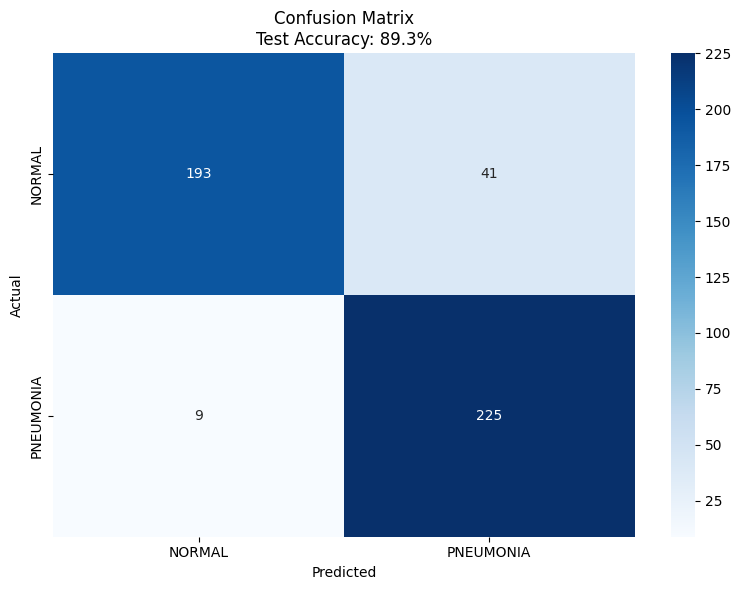


📈 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      NORMAL       0.96      0.82      0.89       234
   PNEUMONIA       0.85      0.96      0.90       234

    accuracy                           0.89       468
   macro avg       0.90      0.89      0.89       468
weighted avg       0.90      0.89      0.89       468


🎯 CLASS-WISE PERFORMANCE:
NORMAL accuracy: 82.5% (234 images)
PNEUMONIA accuracy: 96.2% (234 images)


In [7]:
if 'test_gen' in locals():
    print("🔄 Evaluating model on full test set...")
    
    # Reset generator
    test_gen.reset()
    
    # Get predictions for all test images
    predictions = model.predict(test_gen, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    true_classes = test_gen.classes
    
    # Calculate accuracy
    accuracy = np.mean(predicted_classes == true_classes)
    print(f"\n📊 FULL TEST SET RESULTS:")
    print(f"Total images: {len(true_classes)}")
    print(f"Test Accuracy: {accuracy:.2%}")
    
    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['NORMAL', 'PNEUMONIA'],
                yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.title(f'Confusion Matrix\nTest Accuracy: {accuracy:.1%}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    
    # Classification Report
    report = classification_report(true_classes, predicted_classes, 
                                 target_names=['NORMAL', 'PNEUMONIA'])
    print(f"\n📈 DETAILED CLASSIFICATION REPORT:")
    print(report)
    
    # Class-wise accuracy
    normal_mask = true_classes == 0
    pneumonia_mask = true_classes == 1
    
    normal_accuracy = np.mean(predicted_classes[normal_mask] == true_classes[normal_mask])
    pneumonia_accuracy = np.mean(predicted_classes[pneumonia_mask] == true_classes[pneumonia_mask])
    
    print(f"\n🎯 CLASS-WISE PERFORMANCE:")
    print(f"NORMAL accuracy: {normal_accuracy:.1%} ({np.sum(normal_mask)} images)")
    print(f"PNEUMONIA accuracy: {pneumonia_accuracy:.1%} ({np.sum(pneumonia_mask)} images)")
    
else:
    print("⚠️ Cannot run full evaluation - test generator not available!")

## Show Prediction Examples

Let's look at some specific examples of correct and incorrect predictions.

🔍 Finding examples of correct and incorrect predictions...

📋 person135_bacteria_647.jpeg
🔮 Predicted: PNEUMONIA (99.2%)
✅ Actual: PNEUMONIA
✅ CORRECT - Raw score: 0.9923

📋 NORMAL2-IM-0366-0001.jpeg
🔮 Predicted: NORMAL (80.2%)
✅ Actual: NORMAL
✅ CORRECT - Raw score: 0.1984

📋 NORMAL2-IM-0028-0001.jpeg
🔮 Predicted: PNEUMONIA (83.1%)
✅ Actual: NORMAL
❌ INCORRECT - Raw score: 0.8313

📋 person91_bacteria_445.jpeg
🔮 Predicted: PNEUMONIA (88.2%)
✅ Actual: PNEUMONIA
✅ CORRECT - Raw score: 0.8823

📋 person41_virus_88.jpeg
🔮 Predicted: PNEUMONIA (97.1%)
✅ Actual: PNEUMONIA
✅ CORRECT - Raw score: 0.9710

📋 IM-0028-0001.jpeg
🔮 Predicted: NORMAL (92.3%)
✅ Actual: NORMAL
✅ CORRECT - Raw score: 0.0774

📋 person43_virus_92.jpeg
🔮 Predicted: PNEUMONIA (100.0%)
✅ Actual: PNEUMONIA
✅ CORRECT - Raw score: 0.9997

📋 person49_virus_101.jpeg
🔮 Predicted: PNEUMONIA (98.6%)
✅ Actual: PNEUMONIA
✅ CORRECT - Raw score: 0.9860

📋 person120_bacteria_570.jpeg
🔮 Predicted: PNEUMONIA (98.3%)
✅ Actual: PNEUMONIA
✅ CO

C:\Users\LOQ\AppData\Local\Temp\ipykernel_34704\1255307070.py:62: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LOQ\AppData\Local\Temp\ipykernel_34704\1255307070.py:62: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LOQ\AppData\Local\Temp\ipykernel_34704\1255307070.py:62: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LOQ\AppData\Local\Temp\ipykernel_34704\1255307070.py:62: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\LOQ\Downloads\PNEUMONIA DETECTION\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\LOQ\Downloads\PNEUMONIA DETECTION\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: 

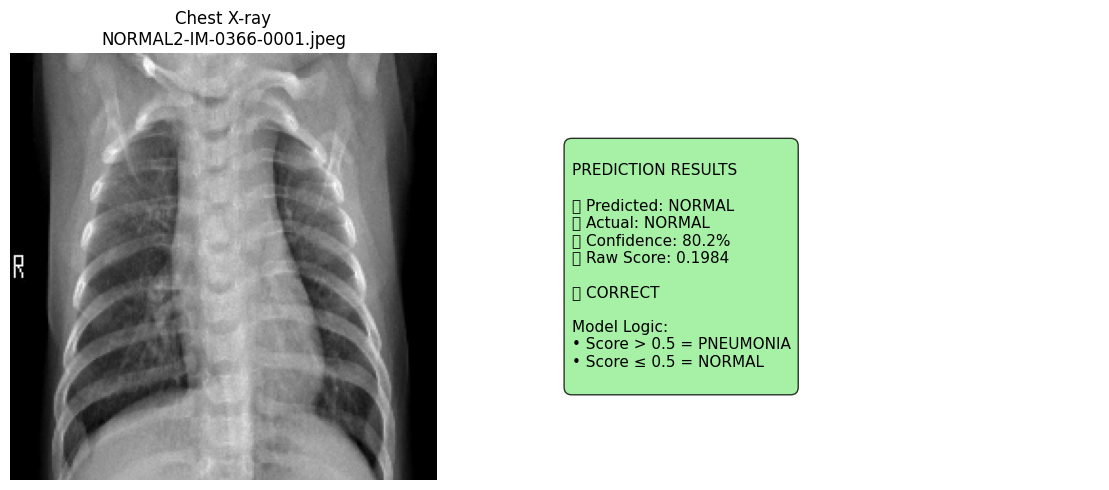


📋 NORMAL2-IM-0366-0001.jpeg
🔮 Predicted: NORMAL (80.2%)
✅ Actual: NORMAL
✅ CORRECT - Raw score: 0.1984

📸 Example: Correctly identified PNEUMONIA case


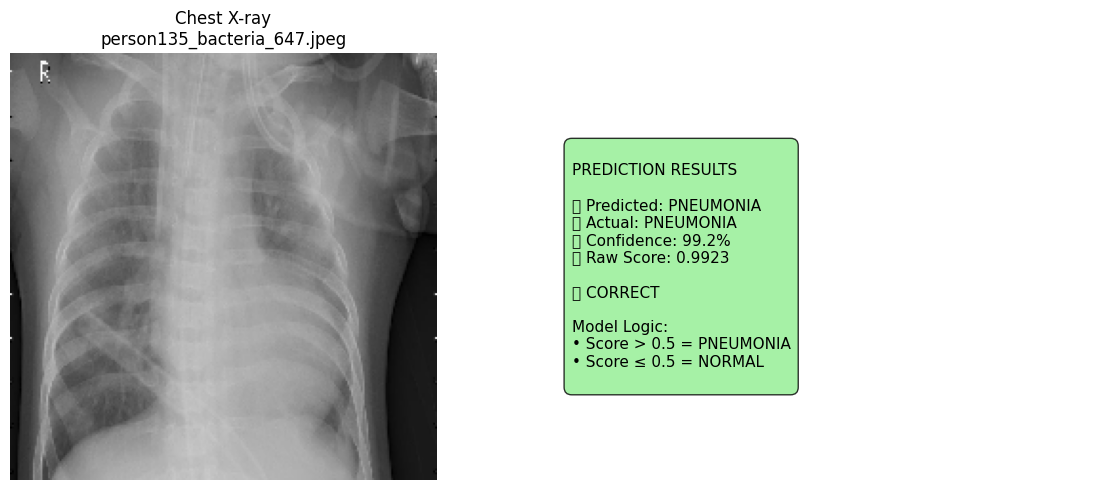


📋 person135_bacteria_647.jpeg
🔮 Predicted: PNEUMONIA (99.2%)
✅ Actual: PNEUMONIA
✅ CORRECT - Raw score: 0.9923

📸 Example: Incorrect prediction (for analysis)


C:\Users\LOQ\AppData\Local\Temp\ipykernel_34704\1255307070.py:62: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\LOQ\Downloads\PNEUMONIA DETECTION\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


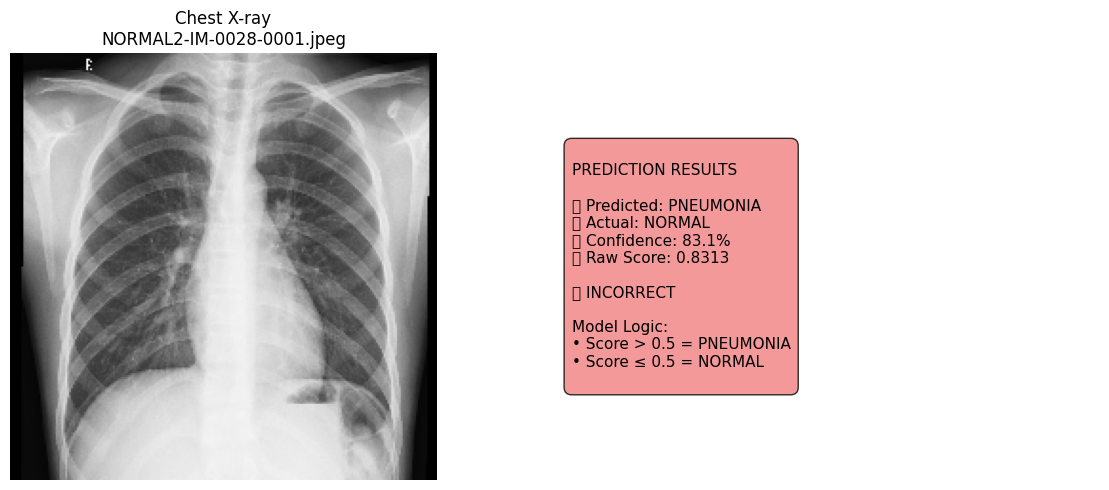


📋 NORMAL2-IM-0028-0001.jpeg
🔮 Predicted: PNEUMONIA (83.1%)
✅ Actual: NORMAL
❌ INCORRECT - Raw score: 0.8313


In [8]:
if 'all_test_images' in locals():
    # Find some correct and incorrect predictions
    print("🔍 Finding examples of correct and incorrect predictions...")
    
    correct_normal = []
    correct_pneumonia = []
    incorrect_predictions = []
    
    # Test a larger sample to find examples
    sample_for_examples = random.sample(all_test_images, min(20, len(all_test_images)))
    
    for img_path in sample_for_examples:
        result = predict_single_image(model, img_path, show_image=False)
        
        if result['is_correct']:
            if result['actual_class'] == 'NORMAL':
                correct_normal.append((img_path, result))
            else:
                correct_pneumonia.append((img_path, result))
        else:
            incorrect_predictions.append((img_path, result))
    
    # Show examples
    print(f"\n✅ Found {len(correct_normal)} correct NORMAL predictions")
    print(f"✅ Found {len(correct_pneumonia)} correct PNEUMONIA predictions")
    print(f"❌ Found {len(incorrect_predictions)} incorrect predictions")
    
    # Display one example from each category if available
    if correct_normal:
        print("\n📸 Example: Correctly identified NORMAL case")
        predict_single_image(model, correct_normal[0][0], show_image=True)
    
    if correct_pneumonia:
        print("\n📸 Example: Correctly identified PNEUMONIA case")
        predict_single_image(model, correct_pneumonia[0][0], show_image=True)
    
    if incorrect_predictions:
        print("\n📸 Example: Incorrect prediction (for analysis)")
        predict_single_image(model, incorrect_predictions[0][0], show_image=True)
    
else:
    print("⚠️ Cannot show examples - test images not loaded!")

## Test Your Own Image

You can test the model on your own chest X-ray image by providing the path below.

In [9]:
# Test your own image
# Replace 'your_image_path.jpg' with the actual path to your image
custom_image_path = 'your_image_path.jpg'  # Change this path

if os.path.exists(custom_image_path):
    print(f"🔍 Testing custom image: {custom_image_path}")
    result = predict_single_image(model, custom_image_path, show_image=True)
else:
    print("💡 To test your own image:")
    print("1. Upload your chest X-ray image to this directory")
    print("2. Change 'custom_image_path' above to your image filename")
    print("3. Run this cell again")
    
    # Show available image files
    image_files = [f for f in os.listdir('.') if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if image_files:
        print("\nAvailable image files in current directory:")
        for img in image_files:
            print(f"  - {img}")

💡 To test your own image:
1. Upload your chest X-ray image to this directory
2. Change 'custom_image_path' above to your image filename
3. Run this cell again

Available image files in current directory:
  - AUGMENTED IMG.png
  - CLASS DIST PER SPLIT.png
  - CNN Test Acc.png
  - DenseNet121 Test Acc.png
  - DenseNet121 Train Acc.png
  - Grad-CAM visualization.png
  - RANDOM IMG PER CLASS.png
  - ResNet Test Acc.png
  - TRAIN AND VALIDATION ACC OF DENSENET 121.png


## Summary

This notebook demonstrates how to:

1. **Load your trained model** and test it on new images
2. **Make predictions** on individual chest X-ray images
3. **Evaluate model performance** on the test dataset
4. **Visualize results** with confusion matrices and examples
5. **Analyze correct and incorrect predictions** to understand model behavior

### Key Points:
- The model outputs a probability score between 0 and 1
- Score > 0.5 = PNEUMONIA, Score ≤ 0.5 = NORMAL
- Higher confidence scores indicate more certain predictions
- Always validate predictions with medical professionals in real applications

### Next Steps:
- Test the model on more diverse datasets
- Analyze failure cases to improve the model
- Consider ensemble methods for better performance
- Implement Grad-CAM for visual explanations